In [53]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import plotly.express as px
from plotly.subplots import make_subplots
import datetime
from scipy.stats import norm,probplot
import math
from sklearn.preprocessing import StandardScaler
import plotly.graph_objects as go
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score,silhouette_samples
import matplotlib.cm as cm

In [2]:
df = pd.read_csv('/kaggle/input/retail-dataset-refined/refined-dataset.csv').drop(['Unnamed: 0'],axis=1)
print(df.shape)
df.head()

(397884, 9)


,InvoiceNo,StockCode,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Description,Amount
0,536365,85123A,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,WHITE HANGING HEART T-LIGHT HOLDER,15.30
1,536365,71053,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,WHITE METAL LANTERN,20.34
2,536365,84406B,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom,CREAM CUPID HEARTS COAT HANGER,22.00
3,536365,84029G,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,KNITTED UNION FLAG HOT WATER BOTTLE,20.34
4,536365,84029E,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,RED WOOLLY HOTTIE WHITE HEART.,20.34


In [3]:
# Function to view basic properties of the data
def display_profile(data):
    shape = data.shape[0]
    types = data.dtypes
    count = data.apply(lambda x: x.count())
    nulls = data.apply(lambda x: x.isnull().sum())
    distincts = data.apply(lambda x: x.unique().shape[0])
    missing_ratio = (data.isnull().sum())/shape*100
    skewness = data.skew(numeric_only = True)
    kurtosis = data.kurt(numeric_only=True)
    std = data.std(numeric_only=True)
    numeric_cols = data.select_dtypes(include=['number']).columns

    minimum = data.min(numeric_only=True)# data.apply(lambda x: x.min(numeric_only=True))
    maximum = data.max(numeric_only=True)# data.apply(lambda x: x.max(numeric_only=True))
    mean = data.mean(numeric_only=True)
    q1 = data.quantile(0.25,numeric_only=True)
    q2 = data.quantile(0.5,numeric_only=True)
    q3 = data.quantile(0.75,numeric_only=True)
    cols = ['types','count','nulls','distincts','skewness','kurtosis','min','max','mean','25%','50%','75%','std']
    df = pd.concat([types,count,nulls,distincts,skewness,kurtosis,minimum,maximum,mean,q1,q2,q3,std],axis = 1)
    df.columns = cols
    display(df)
    return df

In [4]:
profile = display_profile(df)

,types,count,nulls,distincts,skewness,kurtosis,min,max,mean,25%,50%,75%,std
InvoiceNo,int64,397884,0,18532,-0.178524,-1.200748,536365.000,581587.00,560616.934451,549234.00,561893.00,572090.00,13106.117773
StockCode,object,397884,0,3665,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Quantity,int64,397884,0,301,409.892972,178186.243253,1.000,80995.00,12.988238,2.00,6.00,12.00,179.331775
InvoiceDate,object,397884,0,17282,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
UnitPrice,float64,397884,0,440,204.032727,58140.396673,0.001,8142.75,3.116488,1.25,1.95,3.75,22.097877
CustomerID,float64,397884,0,4338,0.025729,-1.180822,12346.000,18287.00,15294.423453,13969.00,15159.00,16795.00,1713.141560
Country,object,397884,0,37,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Description,object,397884,0,3647,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Amount,float64,397884,0,2810,451.443182,232155.117219,0.001,168469.60,22.397000,4.68,11.80,19.80,309.071041


In [5]:
df['InvoiceNo'] = df['InvoiceNo'].astype('str')
df['CustomerID'] = df['CustomerID'].astype('int').astype('str')
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])

In [6]:
profile = display_profile(df)

,types,count,nulls,distincts,skewness,kurtosis,min,max,mean,25%,50%,75%,std
InvoiceNo,object,397884,0,18532,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
StockCode,object,397884,0,3665,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Quantity,int64,397884,0,301,409.892972,178186.243253,1.000,80995.00,12.988238,2.00,6.00,12.00,179.331775
InvoiceDate,datetime64[ns],397884,0,17282,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
UnitPrice,float64,397884,0,440,204.032727,58140.396673,0.001,8142.75,3.116488,1.25,1.95,3.75,22.097877
CustomerID,object,397884,0,4338,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Country,object,397884,0,37,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Description,object,397884,0,3647,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Amount,float64,397884,0,2810,451.443182,232155.117219,0.001,168469.60,22.397000,4.68,11.80,19.80,309.071041


# Customer Segmentation

RFM model can be used to understand the behaviour of customers. 
* R: **Recency**: How recent has customer done a transaction.
* F: **Frequency**: How frequent has customer done transactions within a time span.
* M: **Monetary** value: Amount of money spend by customer

### Recency

In [7]:
referance_date = df.InvoiceDate.max()+datetime.timedelta(days = 1)
print(f'Referance date is {referance_date}')
df['days_since_last_purchase'] = (referance_date - df['InvoiceDate']).dt.days

Referance date is 2011-12-10 12:50:00


In [8]:
customer_history = df[['CustomerID','days_since_last_purchase']].\
                    groupby(by='CustomerID')['days_since_last_purchase'].min().reset_index()
customer_history = customer_history.rename({'days_since_last_purchase':'recency'},axis=1)
profile = display_profile(customer_history)

,types,count,nulls,distincts,skewness,kurtosis,min,max,mean,25%,50%,75%,std
CustomerID,object,4338,0,4338,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
recency,int64,4338,0,349,1.246048,0.430576,1.0,374.0,92.536422,18.0,51.0,142.0,100.014169


Plot the Recency distribution and its QQ-plot

In [9]:
mean,std = norm.fit(customer_history.recency)

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


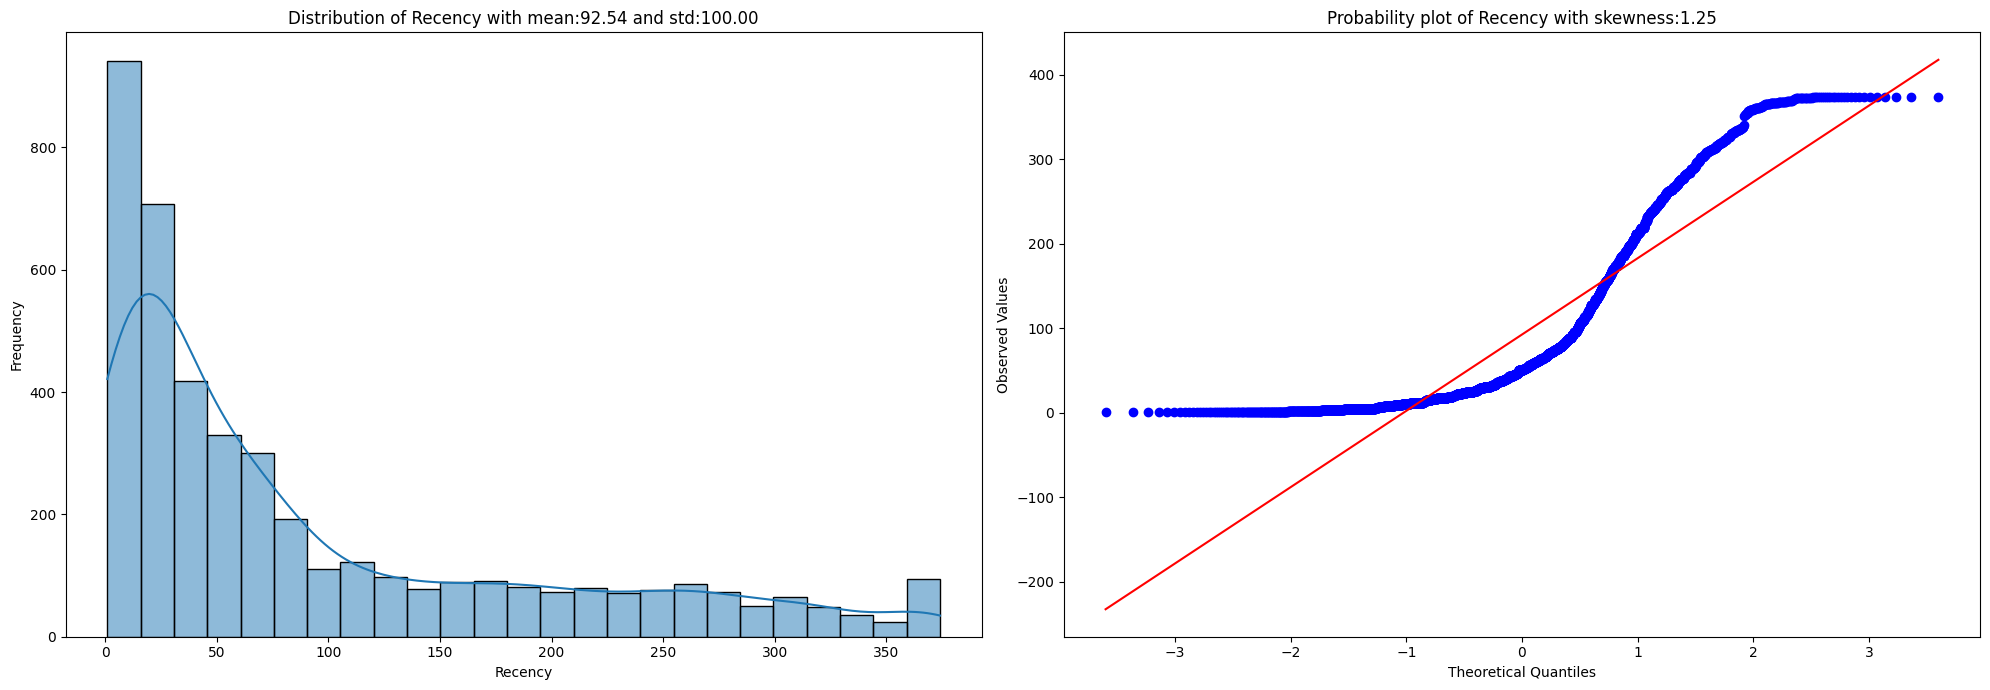

In [10]:
fig = plt.figure(figsize=(20,7))
fig1 = fig.add_subplot(121)
sns.histplot(customer_history.recency,fill=norm,kde=True)
fig1.set_title(f"Distribution of Recency with mean:{mean:.2f} and std:{std:.2f}",loc='center')
fig1.set_xlabel("Recency")
fig1.set_ylabel("Frequency")

fig2 = fig.add_subplot(122)
l = probplot(customer_history.recency,dist='norm',fit=True,plot=fig2)
fig2.set_title(f"Probability plot of Recency with skewness:{customer_history.recency.skew():.2f}",loc='center')
fig2.set_xlabel("Theoretical Quantiles")
fig2.set_ylabel("Observed Values")
plt.tight_layout()
plt.show()

Highly skewed data. QQ plot doesn't allign with the normal distribution line.

### Frequency

In [11]:
customer_freq = df[['CustomerID','InvoiceNo']].groupby(by='CustomerID')['InvoiceNo'].count().\
                reset_index(name='frequency')

In [12]:
profile = display_profile(customer_freq)

,types,count,nulls,distincts,skewness,kurtosis,min,max,mean,25%,50%,75%,std
CustomerID,object,4338,0,4338,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
frequency,int64,4338,0,460,18.106165,483.431675,1.0,7847.0,91.720609,17.0,41.0,100.0,228.785094


In [13]:
mean,std = norm.fit(customer_freq.frequency)

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


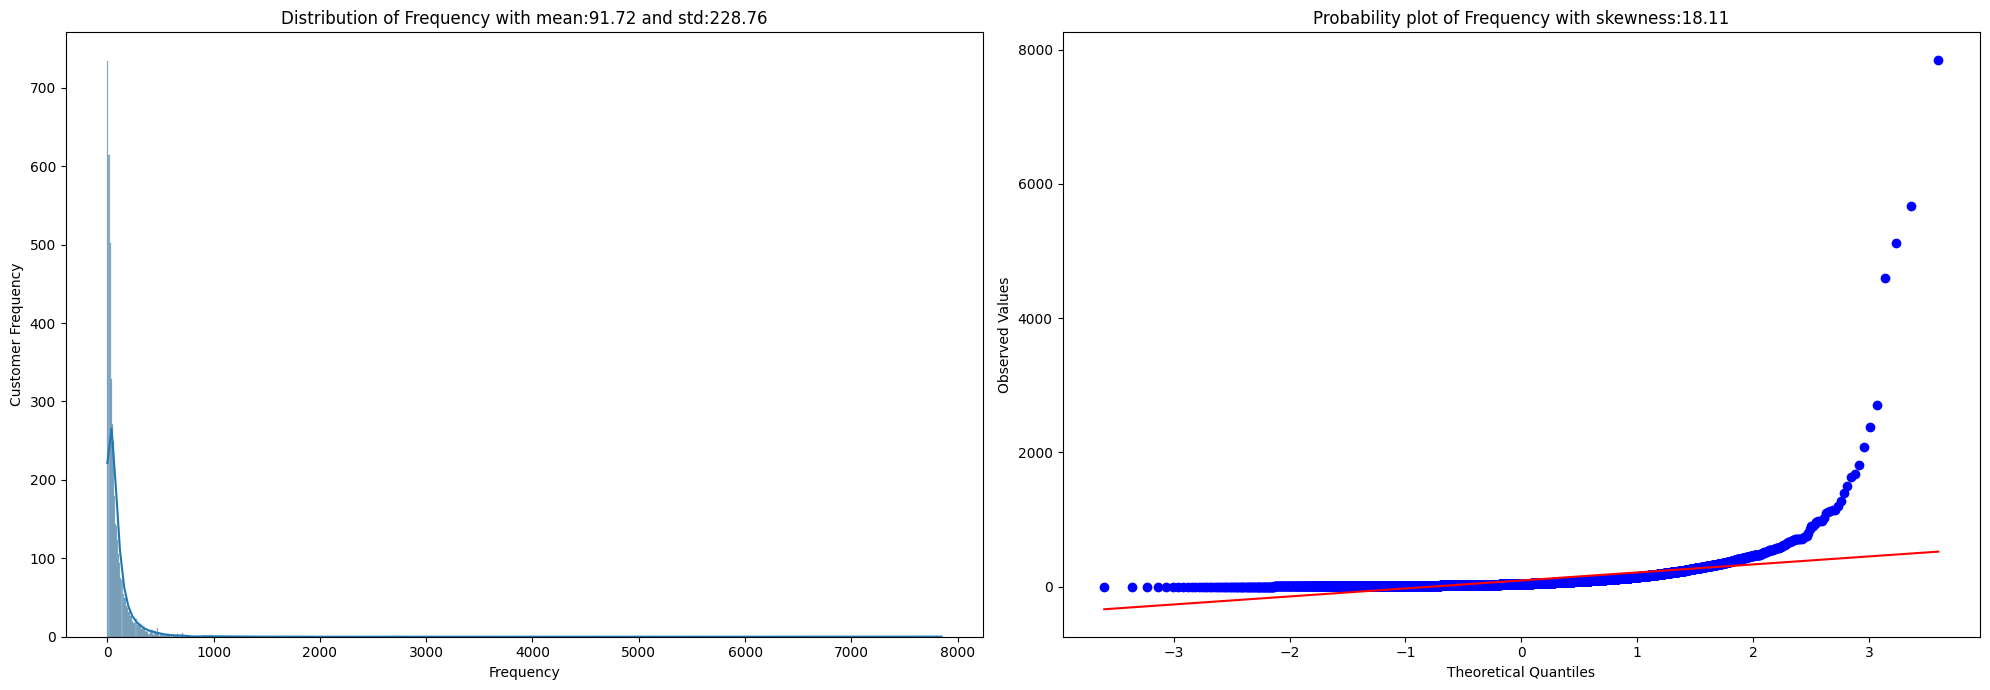

In [14]:
fig = plt.figure(figsize=(20,7))
fig1 = fig.add_subplot(121)
sns.histplot(customer_freq.frequency,fill=norm,kde=True)
fig1.set_title(f"Distribution of Frequency with mean:{mean:.2f} and std:{std:.2f}",loc='center')
fig1.set_xlabel("Frequency")
fig1.set_ylabel("Customer Frequency")

fig2 = fig.add_subplot(122)
l = probplot(customer_freq.frequency,dist='norm',fit=True,plot=fig2)
fig2.set_title(f"Probability plot of Frequency with skewness:{customer_freq.frequency.skew():.2f}",loc='center')
fig2.set_xlabel("Theoretical Quantiles")
fig2.set_ylabel("Observed Values")
plt.tight_layout()
plt.show()

Too much skewed data.

In [15]:
customer_history = customer_history.merge(customer_freq,on='CustomerID')

### Monetary Value

In [16]:
customer_monetary = df[['CustomerID','Amount']].groupby(by='CustomerID')['Amount'].sum().\
                reset_index(name='Amount')
profile = display_profile(customer_monetary)

,types,count,nulls,distincts,skewness,kurtosis,min,max,mean,25%,50%,75%,std
CustomerID,object,4338,0,4338,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Amount,float64,4338,0,4248,19.324953,478.048121,3.75,280206.02,2054.26646,307.415,674.485,1661.74,8989.230441


/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


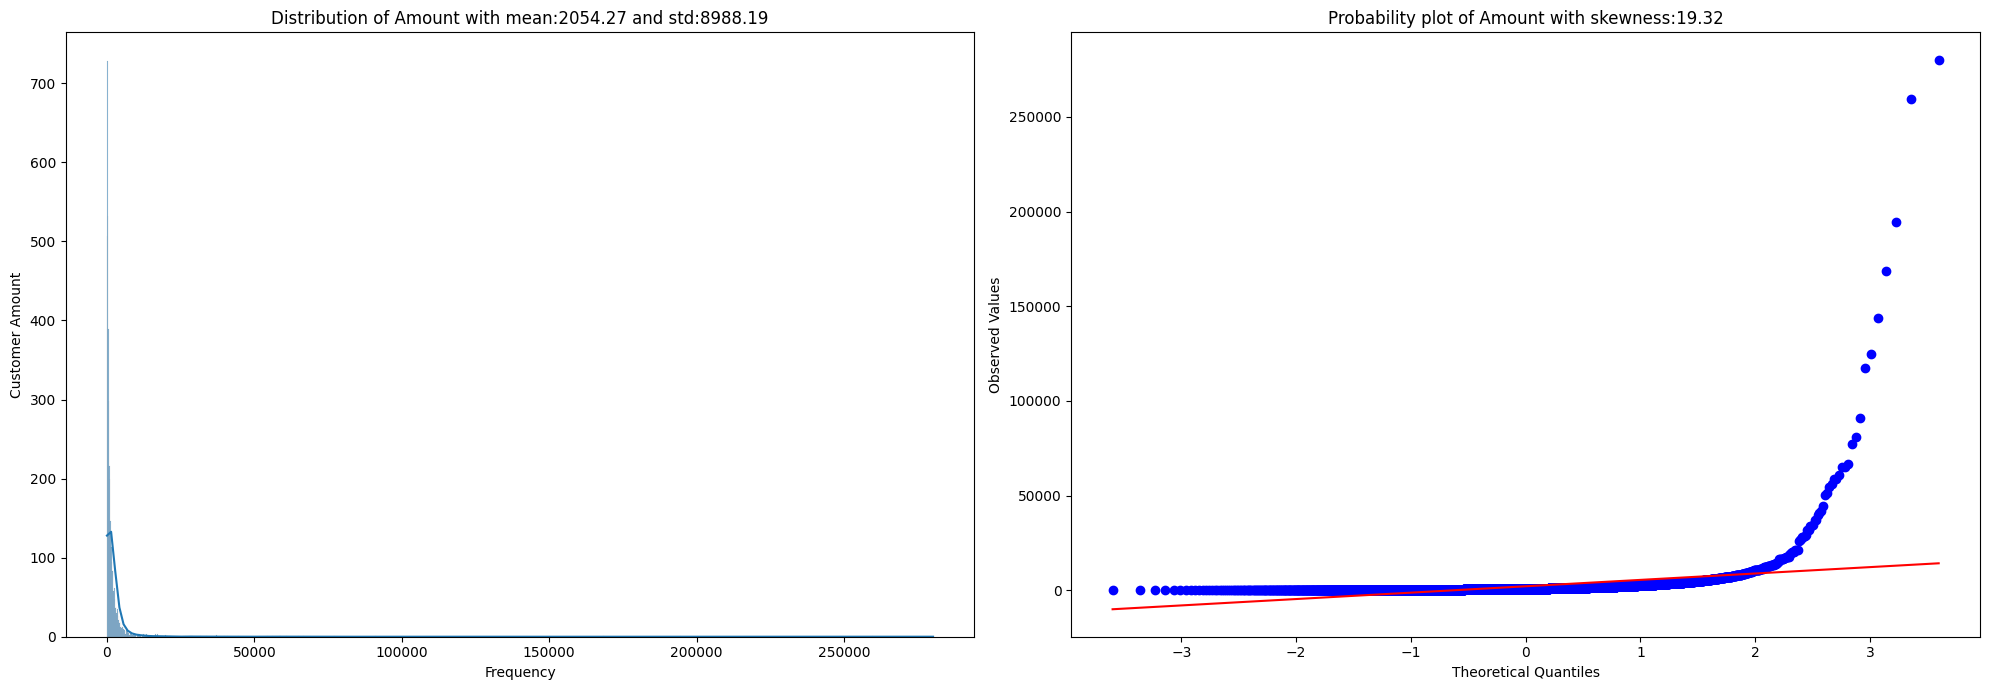

In [17]:
mean,std = norm.fit(customer_monetary.Amount)
fig = plt.figure(figsize=(20,7))
fig1 = fig.add_subplot(121)
sns.histplot(customer_monetary.Amount,fill=norm,kde=True)
fig1.set_title(f"Distribution of Amount with mean:{mean:.2f} and std:{std:.2f}",loc='center')
fig1.set_xlabel("Frequency")
fig1.set_ylabel("Customer Amount")

fig2 = fig.add_subplot(122)
l = probplot(customer_monetary.Amount,dist='norm',fit=True,plot=fig2)
fig2.set_title(f"Probability plot of Amount with skewness:{customer_monetary.Amount.skew():.2f}",loc='center')
fig2.set_xlabel("Theoretical Quantiles")
fig2.set_ylabel("Observed Values")
plt.tight_layout()
plt.show()

In [18]:
customer_history = customer_history.merge(customer_monetary,on='CustomerID')

In [19]:
profile = display_profile(customer_history)

,types,count,nulls,distincts,skewness,kurtosis,min,max,mean,25%,50%,75%,std
CustomerID,object,4338,0,4338,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
recency,int64,4338,0,349,1.246048,0.430576,1.00,374.00,92.536422,18.000,51.000,142.00,100.014169
frequency,int64,4338,0,460,18.106165,483.431675,1.00,7847.00,91.720609,17.000,41.000,100.00,228.785094
Amount,float64,4338,0,4248,19.324953,478.048121,3.75,280206.02,2054.266460,307.415,674.485,1661.74,8989.230441


## Data preprocessing

Performing log transformation of all features(as they are highly right skewed), followed by standard scaling them

In [20]:
customer_history['recency_log'] = customer_history['recency'].apply(math.log)
customer_history['frequency_log'] = customer_history['frequency'].apply(math.log)
customer_history['amount_log'] = customer_history['Amount'].apply(math.log)
features = ['recency_log','frequency_log','amount_log']
data = customer_history[features]
scaler = StandardScaler()
data = scaler.fit_transform(data)
data_df = pd.DataFrame(data,columns=features)
profile = display_profile(data_df)

,types,count,nulls,distincts,skewness,kurtosis,min,max,mean,25%,50%,75%,std
recency_log,float64,4338,0,349,-0.554566,-0.271990,-2.630445,1.505796,-1.048288e-16,-0.612424,0.114707,0.829652,1.000115
frequency_log,float64,4338,0,460,-0.218240,0.212606,-2.775160,3.988157,-9.172520e-17,-0.638433,0.025507,0.697925,1.000115
amount_log,float64,4338,0,4235,0.380936,0.738802,-4.179280,4.721395,-6.879390e-16,-0.684183,-0.060942,0.654244,1.000115


<Axes: xlabel='recency_log', ylabel='amount_log'>

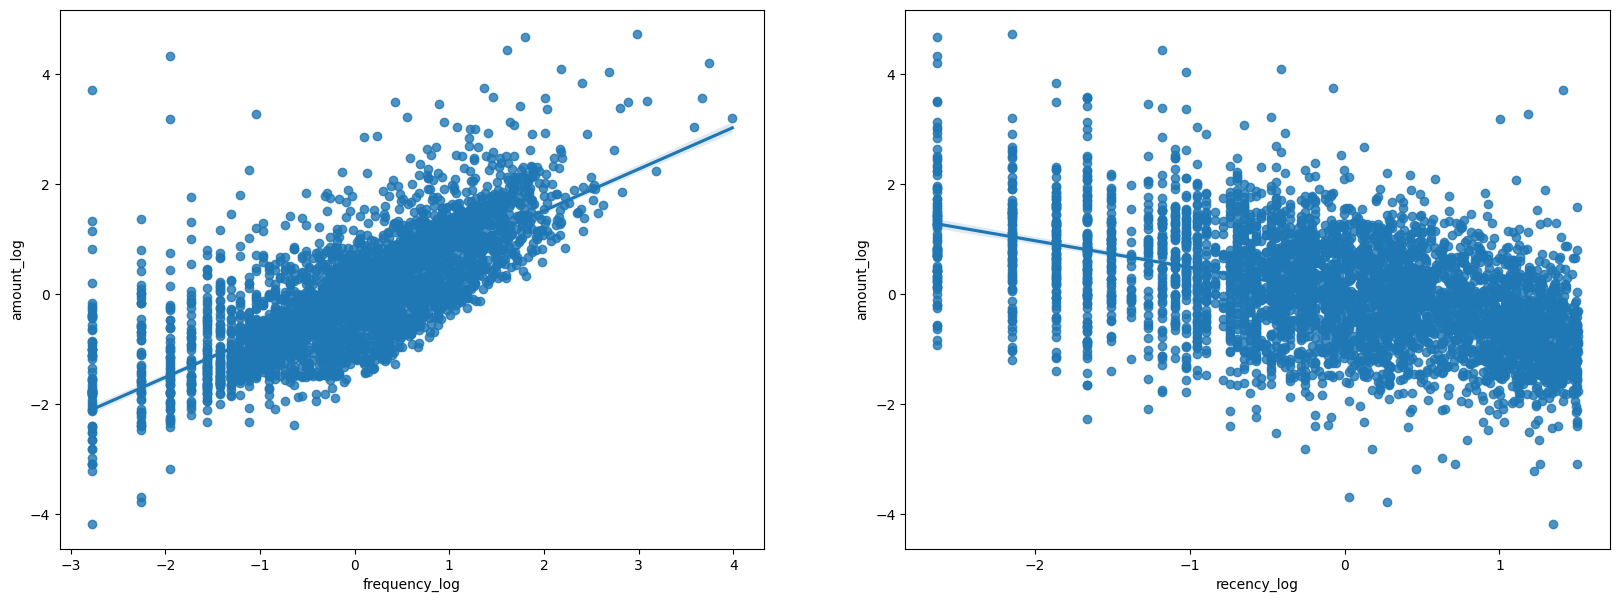

In [21]:
fig = plt.figure(figsize = (20,7))
fig1 = fig.add_subplot(121)
sns.regplot(data = data_df,x = 'frequency_log',y='amount_log')
fig2 = fig.add_subplot(122)
sns.regplot(data = data_df,x = 'recency_log',y='amount_log')

In [ ]:
# fig = plt.figure(figsize=(20,10))
fig = go.Figure(data=[go.Scatter3d(z=data_df.amount_log, x=data_df.frequency_log, y=data_df.recency_log,mode='markers')])
fig.update_layout(title='3D Surface Plot', autosize=True,
                  width=800, height=800,
                  margin=dict(l=40, r=40, b=40, t=40),
                  scene=dict(xaxis=dict(title='frequency_log'),
                             yaxis=dict(title='recency_log'),
                             zaxis=dict(title='amount_log')))
fig.show()

We see, with increase in frequency amount of sales is increasing. And with more recent(less recency value) purchases, there is increase in sales amount. 

## Clustering of segments

# **K-Means Clustering**
Initially starting with K number of random data points from the data, Eucledian distance between every data point from the selected centroids are calculated. Data point with least eucledian distance from a centroid is assigned to that cluster. Aim is to reduce the intra-cluster squared distances. 
* **K-Means++** : Placing the initial centroids far away from each other leads to better clustering
* **Elbow Method** : Drawing the variance vs number of clusters plot gives us the best value of clusters, denoted by the elbow shaped joint at the curve.

In [ ]:
clusters  = 50
cost = []
initital_inertia = 100000000000000
K_best = clusters;
for k in range(1,clusters+1):
    model = KMeans(
                n_clusters=k,
                init='k-means++',
                n_init='warn',
                max_iter=300,
                tol=0.0001,
                random_state=42)
    model.fit(data)
    inertia = model.inertia_
    cost.append(inertia)
    if (K_best == clusters) and (initital_inertia-inertia)/initital_inertia < 0.1:
        K_best = k;
    initital_inertia = inertia
    
    

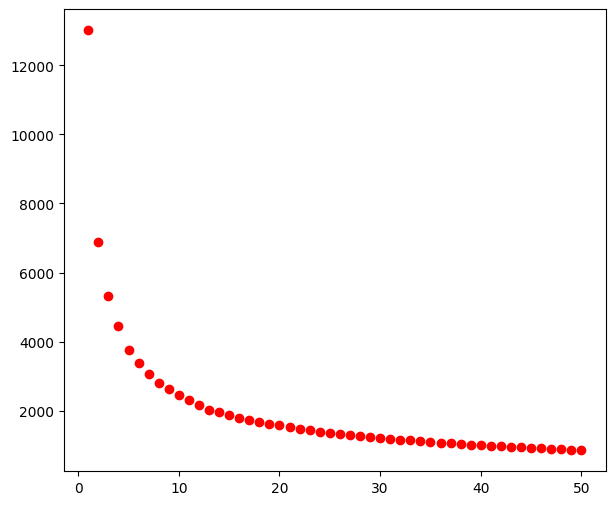

In [24]:
fig = plt.figure(figsize=(7,6))
plt.scatter(range(1,clusters+1),cost,c='red')
plt.show()

In [27]:
print(f"Best Value of k : {K_best}")

Best Value of k : 7


In [26]:
best_model = KMeans(
    n_clusters=K_best,
    init='k-means++',
    n_init='warn',
    max_iter=300,
    tol=0.0001,
    random_state=42)
best_model.fit(data)


/opt/conda/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning



KMeans(n_clusters=7, random_state=42)

In [43]:
labels = best_model.labels_

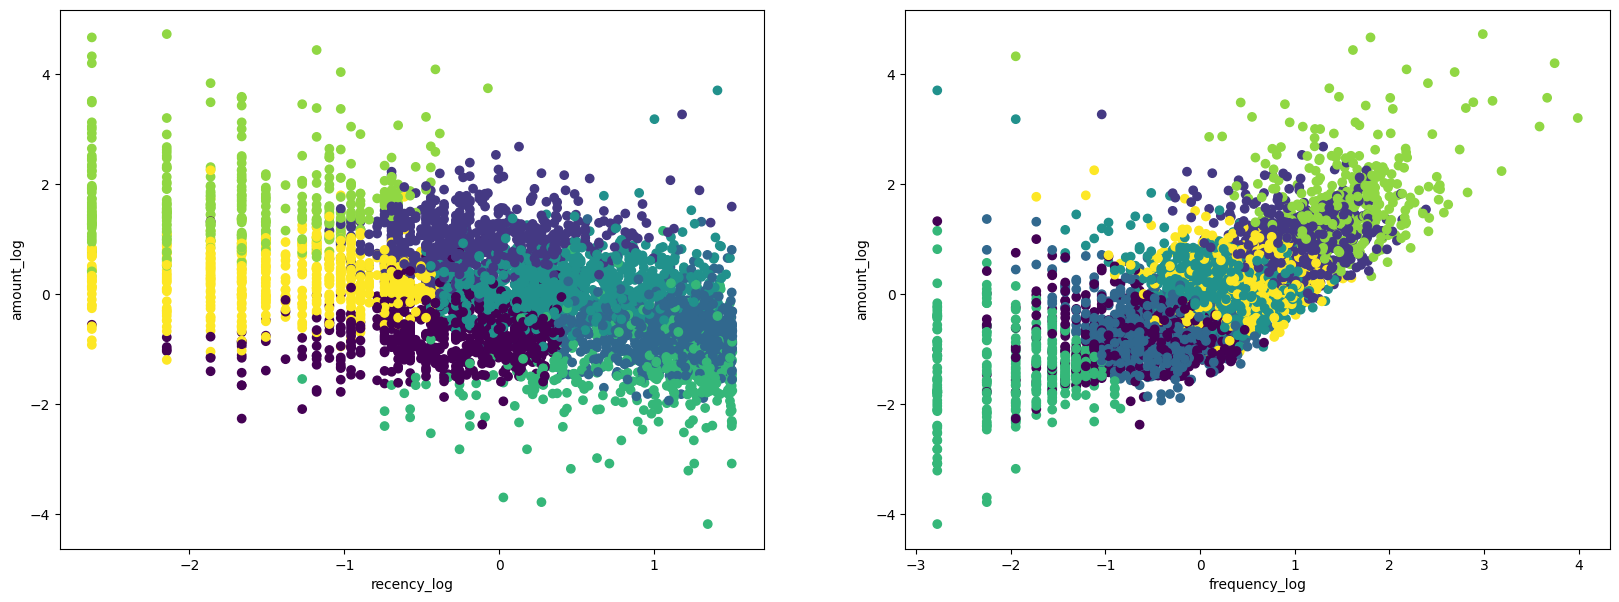

In [ ]:
fig = plt.figure(figsize=(20,7))
ax = fig.add_subplot(121)
plt.scatter(x=data[:,0],y=data[:,2],c = labels.astype(float))
ax.set_xlabel(features[0])
ax.set_ylabel(features[2])

ax = fig.add_subplot(122)
plt.scatter(x=data[:,1],y=data[:,2],c = labels.astype(float))
ax.set_xlabel(features[1])
ax.set_ylabel(features[2])
plt.show()

In [46]:
silscore = silhouette_score(data,labels)

In [48]:
silscore

0.2623136143432745

In [56]:
cluster_centers = dict()

/opt/conda/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning



For n_clusters = 2 The average silhouette_score is : 0.39508567727390814


/opt/conda/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning



For n_clusters = 3 The average silhouette_score is : 0.3036318785071885


/opt/conda/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning



For n_clusters = 4 The average silhouette_score is : 0.30156020353473656


/opt/conda/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning



For n_clusters = 5 The average silhouette_score is : 0.2775389741405628


/opt/conda/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning



For n_clusters = 6 The average silhouette_score is : 0.27617197127692655


/opt/conda/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning



For n_clusters = 7 The average silhouette_score is : 0.2623136143432745


/opt/conda/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning



For n_clusters = 8 The average silhouette_score is : 0.2608685120471772


/opt/conda/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning



For n_clusters = 9 The average silhouette_score is : 0.25719441228019807


/opt/conda/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning



For n_clusters = 10 The average silhouette_score is : 0.264109831266688


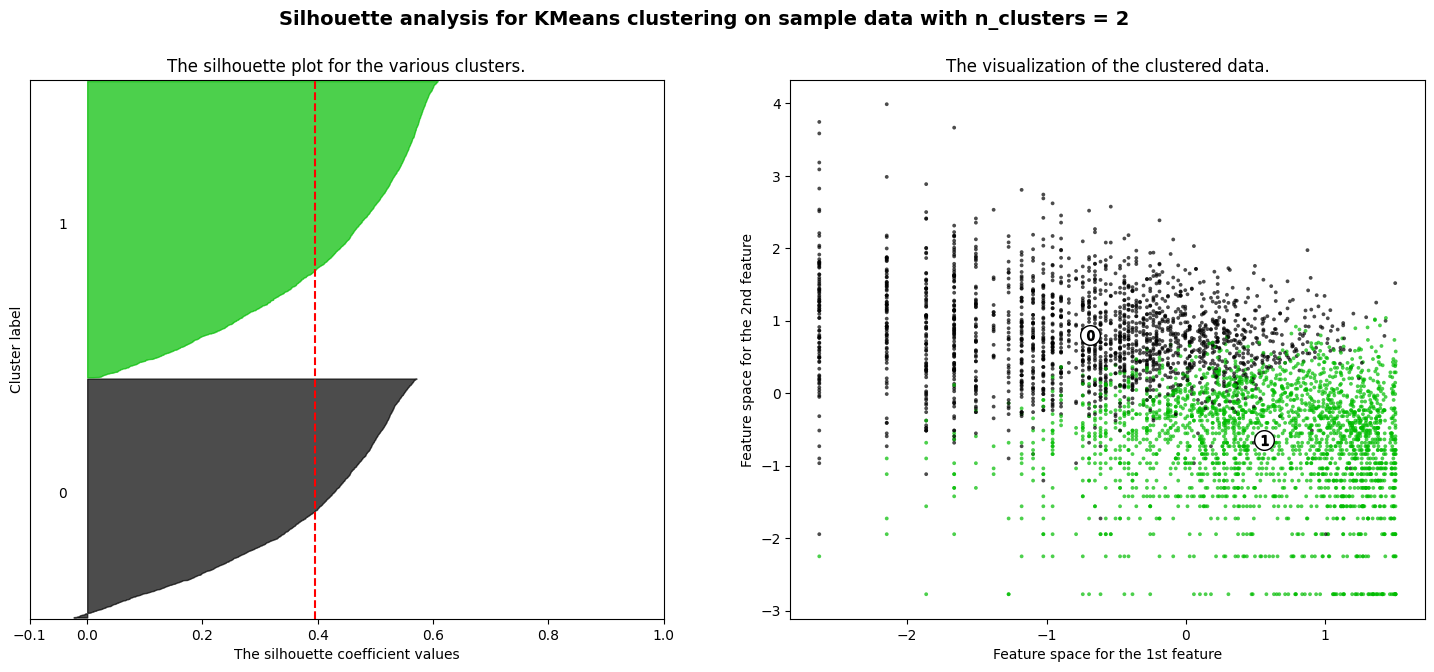

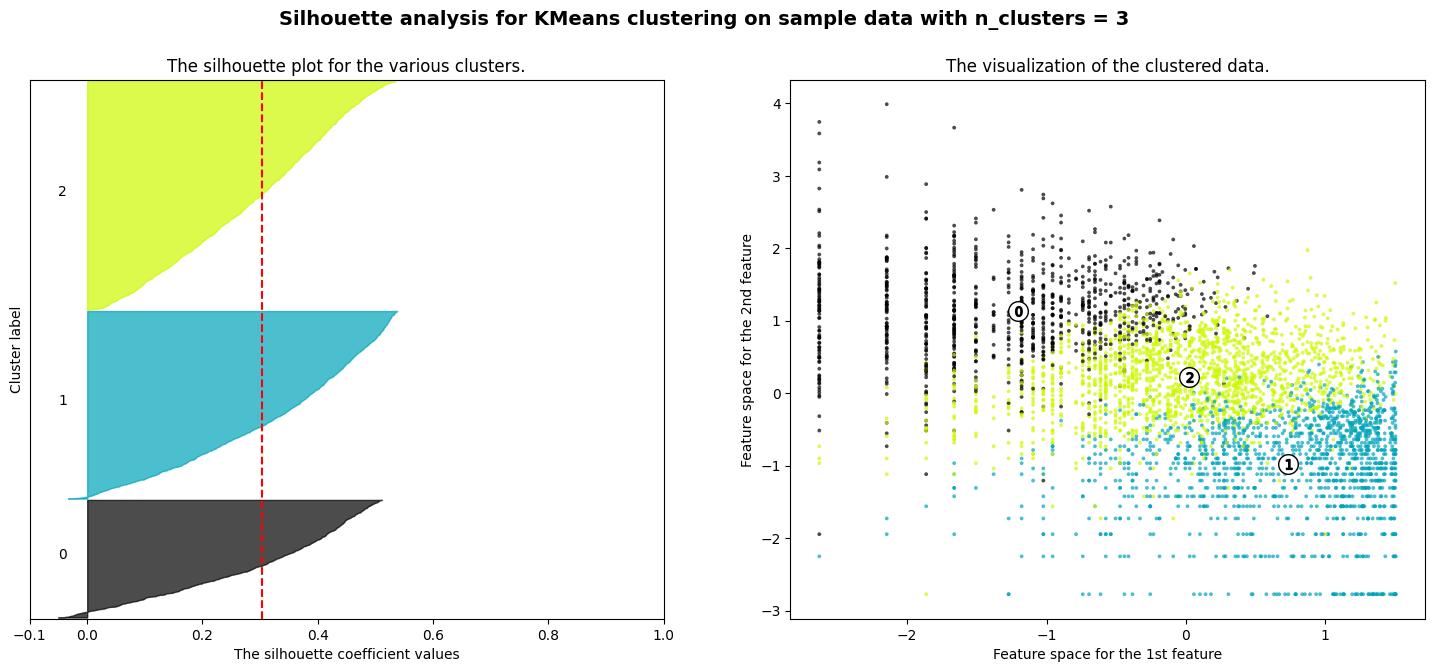

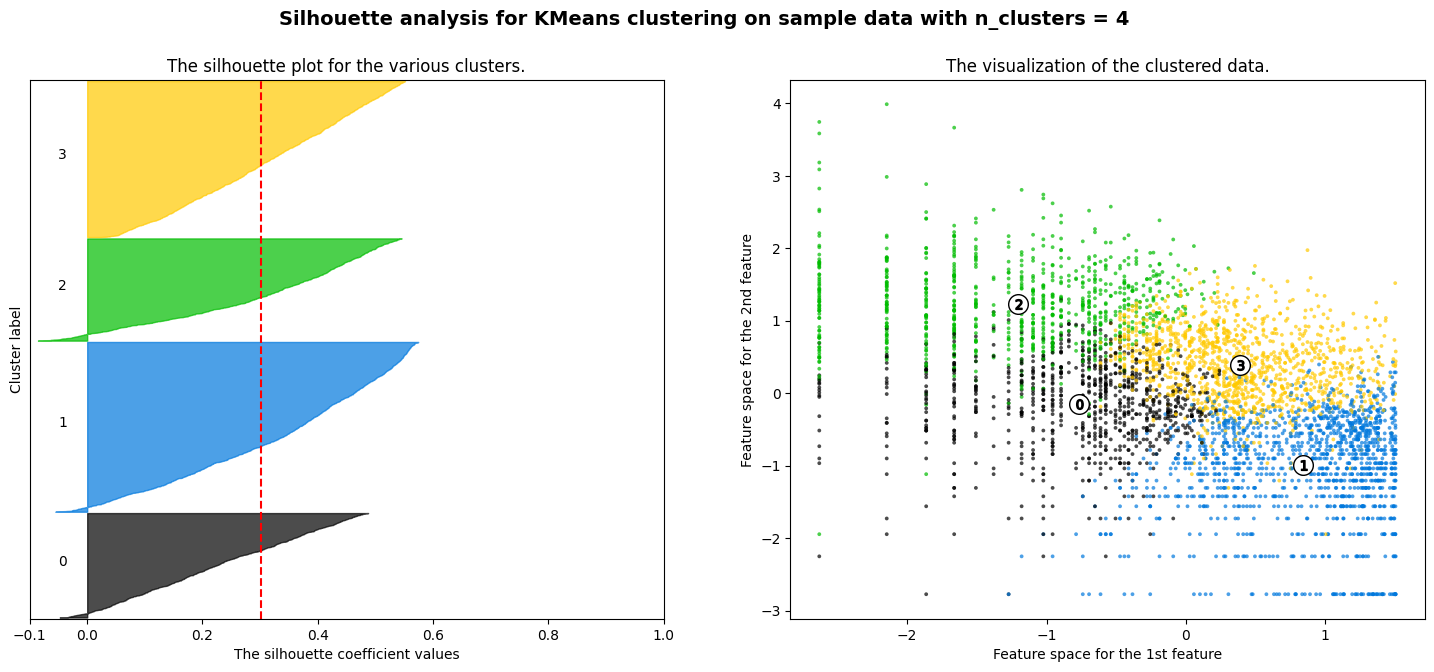

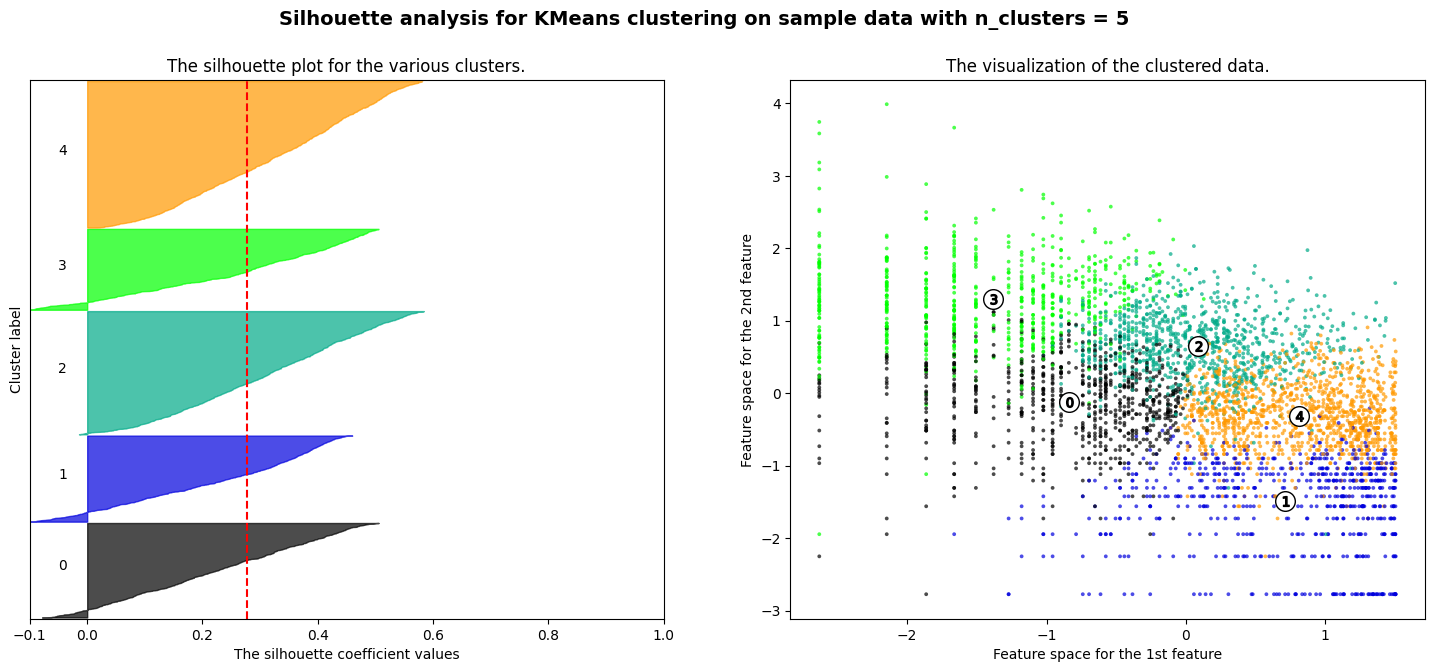

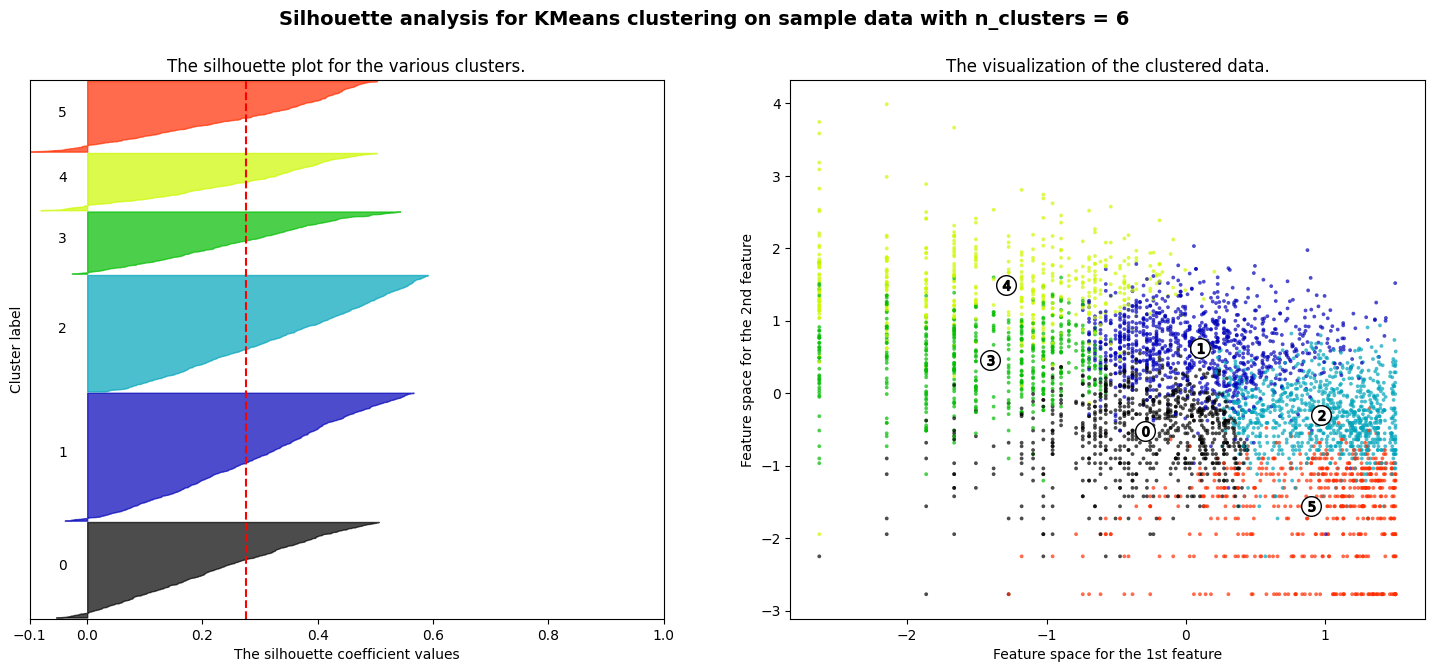

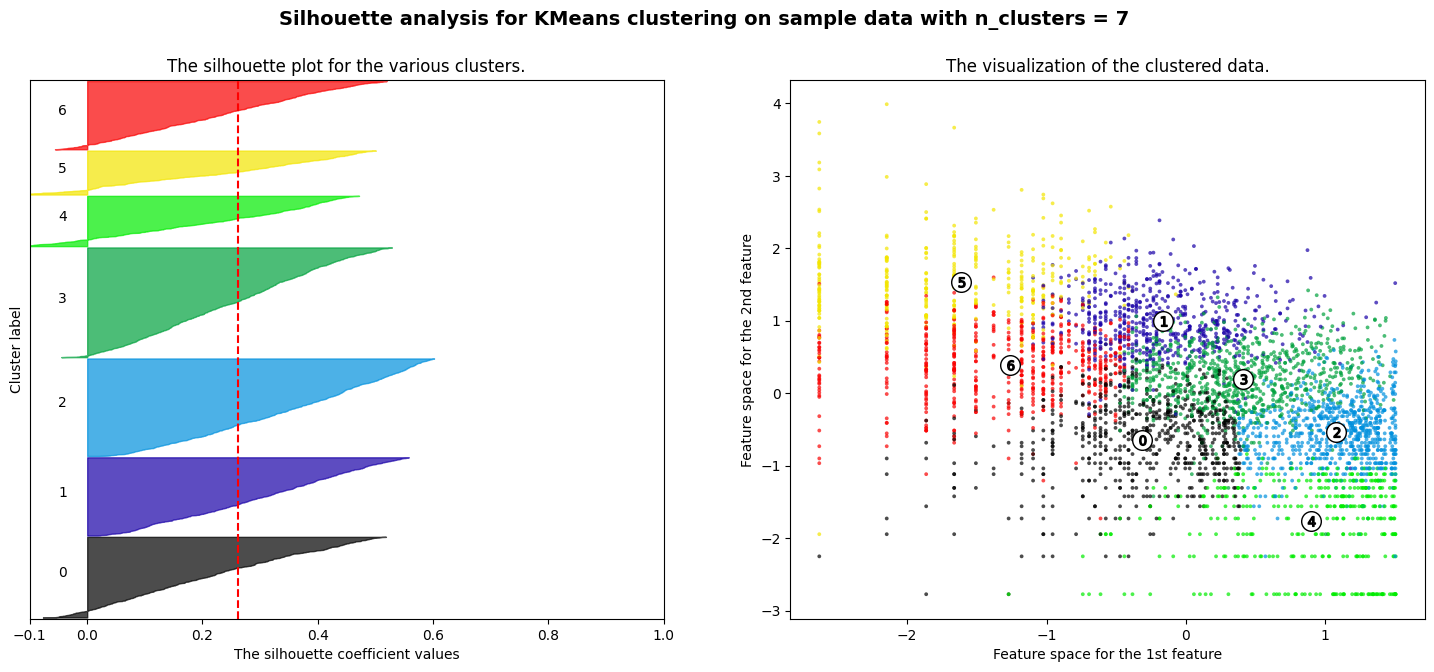

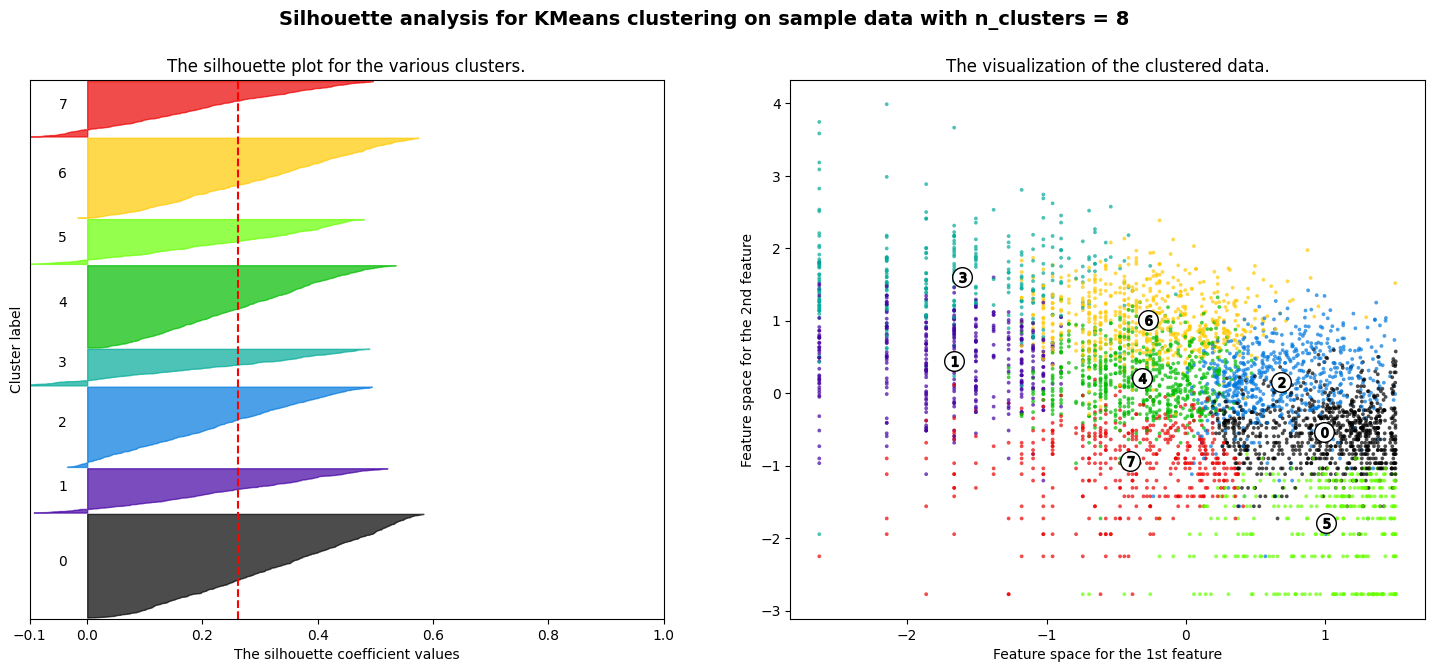

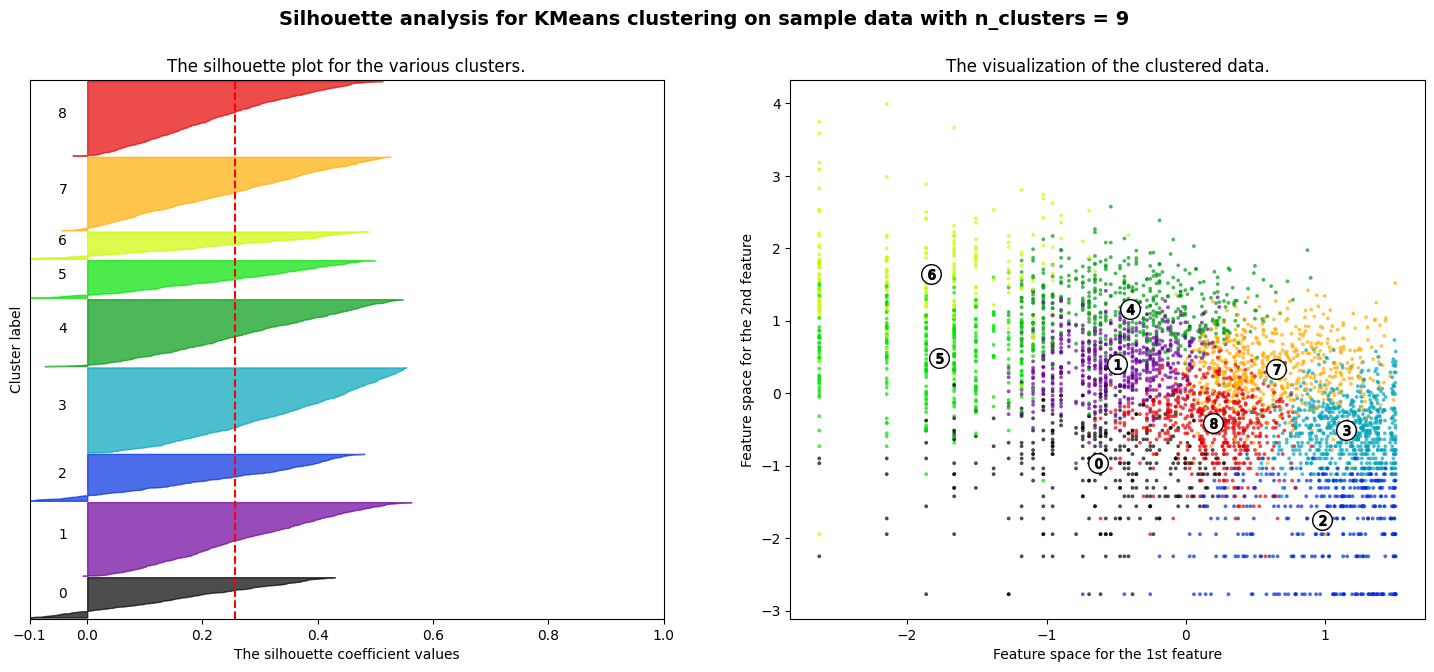

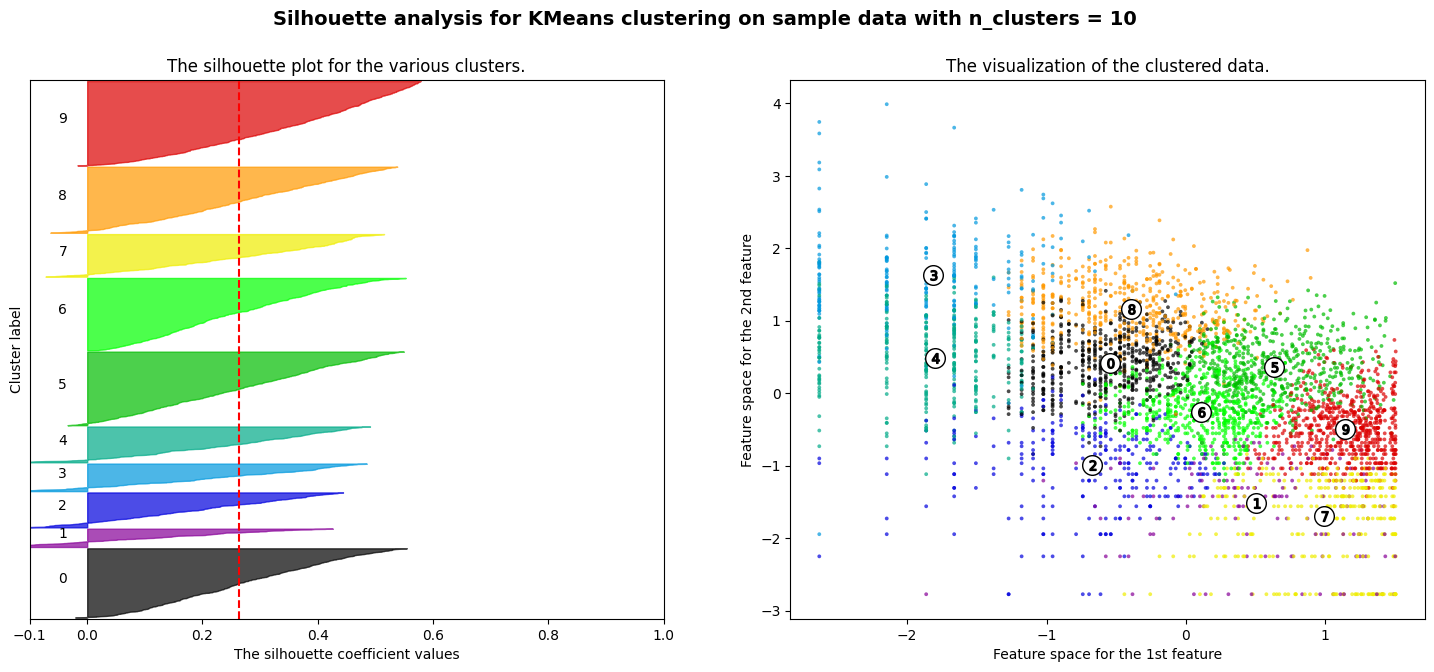

In [57]:
for n_clusters in range(2,K_best+4):
    # Create a subplot with 1 row and 2 columns
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(18, 7)

    # The 1st subplot is the silhouette plot
    # The silhouette coefficient can range from -1, 1 but in this example all
    # lie within [-0.1, 1]
    ax1.set_xlim([-0.1, 1])
    # The (n_clusters+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    ax1.set_ylim([0, len(data) + (n_clusters + 1) * 10])

    # Initialize the clusterer with n_clusters value and a random generator
    # seed of 10 for reproducibility.
    clusterer = KMeans(n_clusters=n_clusters,
                       init='k-means++',
                       n_init='warn',
                       max_iter=500,
                       tol=0.0001,
                       random_state=42)
    cluster_labels = clusterer.fit_predict(data)

    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    silhouette_avg = silhouette_score(data, cluster_labels)
    cluster_centers.update({n_clusters :{'cluster_center':clusterer.cluster_centers_,
                                         'silhouette_score':silhouette_avg,
                                         'labels':cluster_labels}
                           })
    print(
        "For n_clusters =",
        n_clusters,
        "The average silhouette_score is :",
        silhouette_avg,
    )

    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(data, cluster_labels)

    y_lower = 10
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(
            np.arange(y_lower, y_upper),
            0,
            ith_cluster_silhouette_values,
            facecolor=color,
            edgecolor=color,
            alpha=0.7,
        )

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

    # 2nd Plot showing the actual clusters formed
    colors = cm.nipy_spectral(cluster_labels.astype(float) / n_clusters)
    ax2.scatter(
        data[:, 0], data[:, 1], marker=".", s=30, lw=0, alpha=0.7, c=colors, edgecolor="k"
    )

    # Labeling the clusters
    centers = clusterer.cluster_centers_
    # Draw white circles at cluster centers
    ax2.scatter(
        centers[:, 0],
        centers[:, 1],
        marker="o",
        c="white",
        alpha=1,
        s=200,
        edgecolor="k",
    )

    for i, c in enumerate(centers):
        ax2.scatter(c[0], c[1], marker="$%d$" % i, alpha=1, s=50, edgecolor="k")

    ax2.set_title("The visualization of the clustered data.")
    ax2.set_xlabel("Feature space for the 1st feature")
    ax2.set_ylabel("Feature space for the 2nd feature")

    plt.suptitle(
        "Silhouette analysis for KMeans clustering on sample data with n_clusters = %d"
        % n_clusters,
        fontsize=14,
        fontweight="bold",
    )

plt.show()

n_clusters = 2 to 6 gives better silhouette score than n_cluster = 7. Also experiment with 7 clusters onwards is having samples of negative silhoutte values, which isn't good.
So our range of selection of clusters should be from 2 to 6.

**Showing the cluster centres of every cluster to understand the overall activity of customers of those clusters**

In [74]:
cols = ['recency','frequency','amount']
for i in range(2,7):
    print("For {} clusters the silhouette score is {:1.2f}".format(i, cluster_centers[i]['silhouette_score']))
    print("Centers of every clusters")
    inverse_transformed = scaler.inverse_transform(cluster_centers[i]['cluster_center'])
    display(pd.DataFrame(np.exp(inverse_transformed),columns = cols))

For 2 clusters the silhouette score is 0.40
Centers of every clusters


,recency,frequency,amount
0,16.212951,114.047099,1987.482387
1,96.107367,16.789383,322.103487


For 3 clusters the silhouette score is 0.30
Centers of every clusters


,recency,frequency,amount
0,7.682343,177.903604,3358.913612
1,123.161026,10.815524,228.132491
2,44.555385,53.174283,860.862213


For 4 clusters the silhouette score is 0.30
Centers of every clusters


,recency,frequency,amount
0,14.354210,32.213352,500.514435
1,143.935740,10.588851,226.578369
2,7.734708,202.541599,3810.417769
3,75.473608,66.088298,1133.225547


For 5 clusters the silhouette score is 0.28
Centers of every clusters


,recency,frequency,amount
0,13.056378,33.556948,519.317163
1,120.280708,5.520837,151.730242
2,49.142928,94.526341,1627.296816
3,5.935956,220.487190,4299.526820
4,138.579441,26.280828,435.485542


For 6 clusters the silhouette score is 0.28
Centers of every clusters


,recency,frequency,amount
0,28.344670,19.864747,342.789895
1,49.966649,90.126857,1551.608709
2,174.349388,26.772019,443.663658
3,5.806940,72.433761,1115.591726
4,6.831926,289.165155,6094.647265
5,156.867494,5.070512,141.495222


## Analysis

### **For 2 clusters**
* Cluster 0 people are spending much money, much more frequent and have done more recent purchases.
* On the other hand, Cluster 1 people have spend less money, very less frequent transactions, and has not done any purchase for long time

### **For 3 clusters**
* Cluster 0 people have done a significant sales amount of purchases, more frequent and very recent. They are most valuable customers.
* Cluster 1 people rarely do purchases and of less amount. The purchases they made, may be due to some discounts or some immediate need.
* Cluster 2 people have done more purchases and more frequent than cluster 1 people. They can be provided with vouchers and offers to increase their purchases.

**and so on....**
Now, which K value to be taken finally depends on business requirements

### Assigning every customer their cluster value

In [81]:
customer_history = customer_history.drop(['recency_log','frequency_log','amount_log'],axis=1)

In [82]:
customer_history['Clusters_3'] = cluster_centers[3]['labels']
customer_history['Clusters_4'] = cluster_centers[4]['labels']
customer_history['Clusters_5'] = cluster_centers[5]['labels']
customer_history['Clusters_6'] = cluster_centers[6]['labels']

In [83]:
customer_history

,CustomerID,recency,frequency,Amount,Clusters_3,Clusters_4,Clusters_5,Clusters_6
0,12346,326,1,77183.60,2,3,2,1
1,12347,2,182,4310.00,0,2,3,4
2,12348,75,31,1797.24,2,3,2,1
3,12349,19,73,1757.55,2,3,2,1
4,12350,310,17,334.40,1,1,4,2
...,...,...,...,...,...,...,...,...
4333,18280,278,10,180.60,1,1,1,5
4334,18281,181,7,80.82,1,1,1,5
4335,18282,8,12,178.05,1,0,0,0
4336,18283,4,756,2094.88,0,2,3,4


### Plotting PIE chart to show which cluster of people forms how much of the customers base 

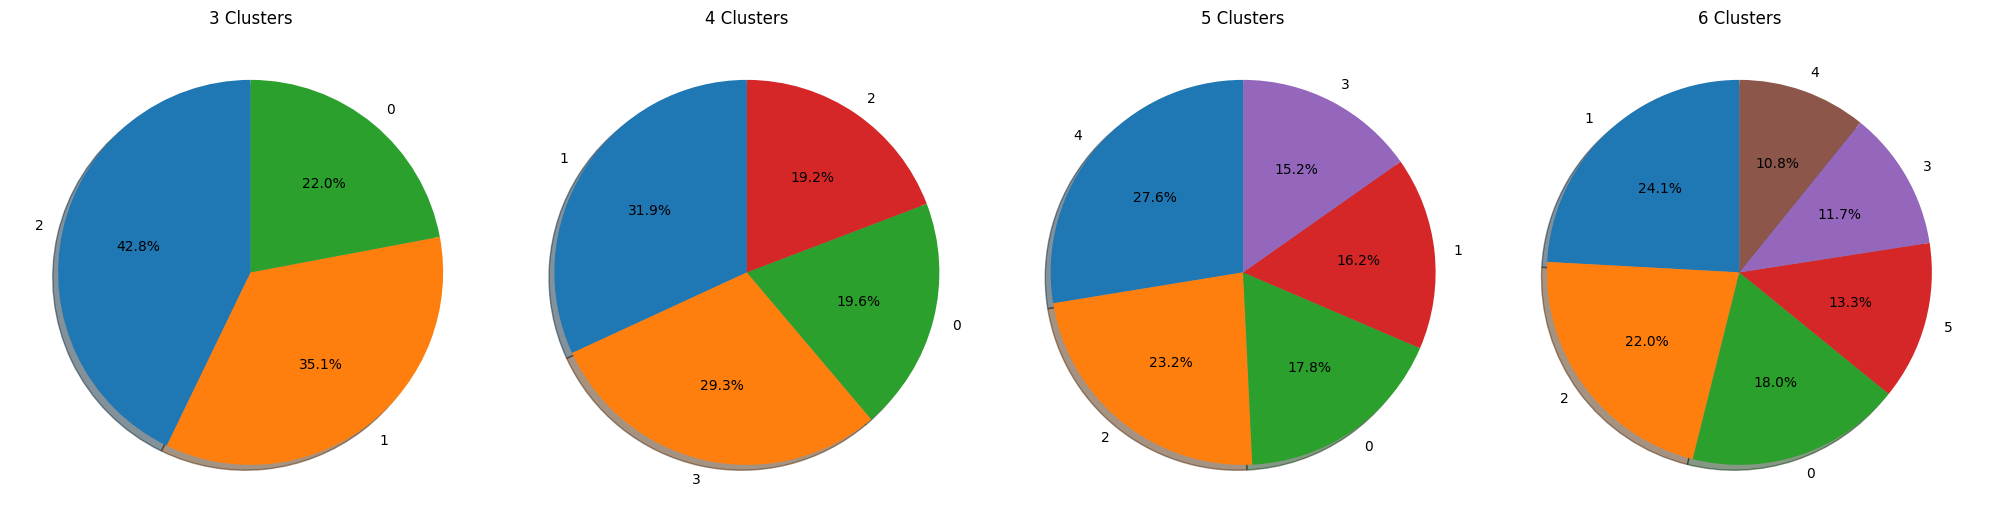

In [89]:
import matplotlib.pyplot as plt

# Create a figure with the specified size
fig = plt.figure(figsize=(20, 7))

# Add the first subplot for 3 clusters
f1 = fig.add_subplot(141)
market = customer_history['Clusters_3'].value_counts()
g = plt.pie(market, labels=market.index, autopct='%1.1f%%', shadow=True, startangle=90)
plt.title('3 Clusters')

# Add the second subplot for 4 clusters
f2 = fig.add_subplot(142)
market = customer_history['Clusters_4'].value_counts()
g = plt.pie(market, labels=market.index, autopct='%1.1f%%', shadow=True, startangle=90)
plt.title('4 Clusters')

# Add the third subplot for 5 clusters
f3 = fig.add_subplot(143)
market = customer_history['Clusters_5'].value_counts()
g = plt.pie(market, labels=market.index, autopct='%1.1f%%', shadow=True, startangle=90)
plt.title('5 Clusters')

# Add the fourth subplot for 6 clusters
f4 = fig.add_subplot(144)
market = customer_history['Clusters_6'].value_counts()
g = plt.pie(market, labels=market.index, autopct='%1.1f%%', shadow=True, startangle=90)
plt.title('6 Clusters')

# Adjust layout
plt.tight_layout()

# Show the plot
plt.show()
